### IMDB Dataset - Classification of Movie Reviews

Let's look at the dataset from the Interneet Movie Database (IMDB) and use it to train a model to classify whether a review is positive or negative.  This is an example of what is called 'sentiment analysis'.  It is used a lot by firms to find out whether their customers are leaving them good or bad reviews, for instance.

In [21]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
import torchtext
from torchtext.datasets import IMDB, SST2
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab
import torch
from torch.utils.data import DataLoader

NUMBER_OF_WORDS = 10000

tokenizer = get_tokenizer('basic_english')
train_data, test_data = IMDB(split=('train', 'test'))

counter = Counter()
for text in train_data:
    counter.update(tokenizer(text[1]))

dict = OrderedDict()
for i, (token, _) in enumerate(counter.most_common(NUMBER_OF_WORDS)):
    dict[token] = i
vocab = Vocab(dict)

def n_hot_encoding(text, vocab):
    indices = [vocab[token] for token in tokenizer(text) if token in vocab]
    one_hot = torch.zeros(len(vocab))
    one_hot[indices] = 1
    return one_hot

BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [23]:
import torch.nn as nn

class ImdbClassifier1(nn.Module):
    def __init__(self):
        super(ImdbClassifier1, self).__init__()
        self.fc1 = nn.Linear(NUMBER_OF_WORDS, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = ImdbClassifier1().to(device)

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [24]:

def train_model():
    model.train()
    count = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        labels = batch[0].float().to(device)
        labels = (labels - 1.0).unsqueeze(1)  # IMDB dataset has labels 1 and 2, convert them to 0 and 1
        texts = batch[1]
        x = torch.stack([n_hot_encoding(text, vocab) for text in texts]).to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1        
    return total_loss/count if count > 0 else -1

def measure_model_loss_only():
    model.train()
    count = 0
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        labels = batch[0].float().to(device)
        labels = (labels - 1.0).unsqueeze(1)  # IMDB dataset has labels 1 and 2, convert them to 0 and 1
        texts = batch[1]
        x = torch.stack([n_hot_encoding(text, vocab) for text in texts]).to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, labels)
        #loss.backward()
        #optimizer.step()
        total_loss += loss.item()
        count += 1        
    return total_loss/count if count > 0 else -1
        

def test_model():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in enumerate(test_loader):
            labels = batch[0].float().to(device)
            labels = (labels - 1.0).unsqueeze(1)  # IMDB dataset has labels 1 and 2, convert them to 0 and 1
            texts = batch[1]
            x = torch.stack([n_hot_encoding(text, vocab) for text in texts]).to(device)
            y_pred = model(x)
            y_pred =  (y_pred > 0.5).float()    # convert to 1.0 if greater than 0.5, 0.0 otherwise
            correct += (y_pred == labels).sum().item()

            total += labels.size(0)
    return (100.0 * correct)/total if total > 0 else -1            

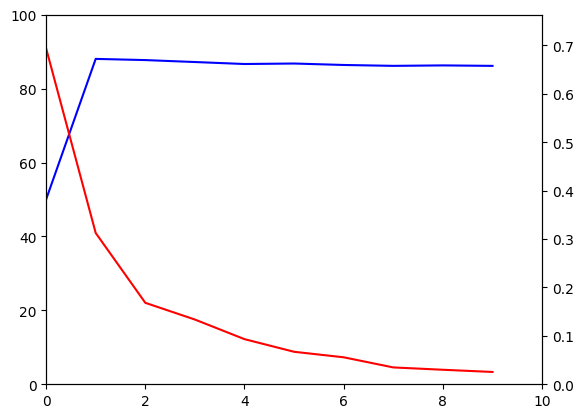

In [25]:
import matplotlib.pyplot as plt

number_of_epochs = 10
losses = []
accuracies = []
epochs = [0]
accuracy = test_model()
accuracies.append(accuracy)
loss = measure_model_loss_only()
losses.append(loss)  # should be max loss - or should calculate with

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # Create a second y-axis

for epoch in range(1, number_of_epochs):
    loss = train_model()
    accuracy = test_model()
    losses.append(loss)
    accuracies.append(accuracy)
    epochs.append(epoch)
    
    ax1.clear()
    ax2.clear()
    ax1.plot(epochs, accuracies, 'b-', label='Accurracy')  
    ax2.plot(epochs, losses, 'r-', label='Loss')  # 'r-' for red line

    ax1.set_xlim(0, number_of_epochs)
    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, max(losses) * 1.1)  # give some headroom for loss line

    #clear_output(wait=True)
    display(fig, clear=True)

plt.close(fig)  # Close the figure when the loop is done


